In [10]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.9'
import jax
import jax.numpy as jnp
import numpy as np
from jax import random, grad, vmap, jit, hessian
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu, elu
# from jax.ops import index_update, index
from jax import lax
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import time
import scipy.optimize as sp_opt



from scipy.interpolate import griddata
from scipy.sparse import csr_matrix
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [11]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [12]:
def solver_perOT(pos1,pos2,gamma):
    dim=pos1.shape[1]
    cost_matrix=np.sum((np.reshape(pos1,(-1,1,dim))-np.reshape(pos2,(1,-1,dim)))**2,axis=2)    
    lsel=100
    nmc = cost_matrix.shape[0]
    m = DP_OT_permutaion(np.min([nmc,lsel]),cost_matrix)
    m.solve(tol=5e-2)
    
    if m.solvestep>0:
        gamma=m.gamma()
    else:
        print(m.solvestep)
    return gamma
class DP_OT_permutaion(object):
    def __init__(self,sz,cost_matrix):
        self.gamma_bsz=sz
        self.gamma_cons_mat_Aeq=construct_gamma_constrain_matrix(self.gamma_bsz)
        self.solvestep=-1
        self.global_step=0
        self.grad_gamma=cost_matrix
        self.N=cost_matrix.shape[0]
        self.show_step=100

    def solve(self,tol=5e-2,repeat_pivot=1,n_max_step=5000):
        start_time=time.time()
        self.idy=np.random.permutation(self.N) # col index for each row
        self.meancost_log=[]
        for step in range(n_max_step):
            indx_chose = self.alg_index(self.grad_gamma, self.idy)
            self.idy[indx_chose], opt_fail = self.alg_update_idy(self.idy[indx_chose], self.grad_gamma[np.ix_(indx_chose, self.idy[indx_chose])],self.gamma_cons_mat_Aeq)
            if step%self.show_step == self.show_step-1:
                self.meancost_log.append(np.sum(self.grad_gamma[[range(self.N)],self.idy])/self.N )
                # print('step: %i, W2: %.3f, step mean time: %.3f, total time: %.1f'%(step+1,self.meancost_log[-1],(time.time()-start_time)/step,(time.time()-start_time)))
                if len(self.meancost_log)>1:
                    if np.abs(self.meancost_log[-1]-self.meancost_log[-2])<tol*0.1:
                        self.solvestep = self.global_step + step
                        break

        self.global_step=self.global_step+n_max_step
        self.mean_cost=self.meancost_log[-1]


    def alg_index(self, grad_gamma, idy):
        # indx_chose = np.argsort(grad_gamma[[range(self.N)],idy],axis=None)[-self.gamma_bsz:]
        indx_chose=np.random.choice(self.N,self.gamma_bsz,replace=False)
        return indx_chose

    def alg_update_idy(self,idy,grad_gamma,gamma_cons_mat_Aeq=None):
        gamma_bsz = grad_gamma.shape[0]
        if gamma_cons_mat_Aeq is None:
            gamma_cons_mat_Aeq = construct_gamma_constrain_matrix(gamma_bsz)
        gamma_1d=np.reshape(np.eye(gamma_bsz),(gamma_bsz*gamma_bsz))
        opt_result = sp_opt.linprog(c=grad_gamma.reshape([gamma_bsz * gamma_bsz]), A_eq=gamma_cons_mat_Aeq,
                                    b_eq=np.matmul(gamma_cons_mat_Aeq, gamma_1d), bounds=(0, None),
                                    method='highs-ipm', options={'ipm_optimality_tolerance': 1e-2})
        if opt_result.x is not None:
            idy_n=idy[np.argmax(np.reshape(opt_result.x,(gamma_bsz,gamma_bsz)),axis=1)]
            return idy_n, 0
        else:
            # print('ips-fail')
            return idy, 1
    def gamma(self):
        matgamma=np.zeros((self.N,self.N))
        matgamma[[range(self.N)],self.idy]=1
        return matgamma
    
def construct_gamma_constrain_matrix( sz):
    A = np.zeros((sz * 2 - 1, sz * sz))
    for i in range(sz):
        A[i, np.arange(sz) + i * sz] = 1
    for i in range(sz - 1):
        A[i + sz, np.arange(sz) * sz + i] = 1
    return A

In [13]:
# Data generator, code in the following archieved for historical traceback

# A non-linear transform to embedding physical parameters     
def sigma_transform(sigma):
    return jnp.log(sigma)/jnp.log(2.0)

class TrainingDataReader: # Used to read data in 'filepath' folder 
    def __init__(self, filepath, n_dict=8, batch_size=200, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.N=np.shape(np.genfromtxt(filepath+'map_0.log',delimiter=',',skip_header=1))[1]-1
        self.n_dict=n_dict
        self.data_set=jnp.zeros([n_dict,self.N,5])
        for i_dict in range(n_dict):
            self.data_set=self.data_set.at[i_dict,:,0:2].set(random.uniform(key,shape=[self.N,2]))
            ## in this we assume data saved in rows, some rows are skipped.
            self.data_set=self.data_set.at[i_dict,:,3:5].set(np.transpose(np.genfromtxt(filepath+'map_'+str(i_dict)+'.log', delimiter=',',usecols=range(self.N),skip_header=3)))
            sigma_read=np.genfromtxt(filepath+'map_'+str(i_dict)+'.log', delimiter=',',usecols=0,skip_footer=4)
            self.data_set=self.data_set.at[i_dict,:,2].set(sigma_transform(sigma_read))
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs= self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        inputs = self.data_set[:,idx,0:3]
        outputs = self.data_set[:,idx,3:5]
        return inputs, outputs



## Prediction Data, historical, renamed
def PredictDataGenerator_1(log2sigma=[-6],size=1000,rng_key=random.PRNGKey(1234)):
    n_dict=np.shape(log2sigma)[0]
    input_=jnp.zeros([n_dict,size,3])
    randomvals=random.uniform(key,shape=[size,2])
    for i in range(n_dict):
        input_=input_.at[i,:,0:2].set(randomvals)
        input_=input_.at[i,:,2].set(log2sigma[i])
    return input_





In [14]:
## Example Generater: For illustration use, no involvement of embedding of physical parameters. 

class TrainingDataGenerator: 
    def __init__(self,n_dict=1, batch_size=200, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.N=100000
        self.data_set=jnp.zeros([n_dict,self.N,5])
        self.key = rng_key
        for i_dict in range(n_dict):
            self.key, subkey = random.split(self.key)
            self.data_set=self.data_set.at[i_dict,:,0:2].set(random.uniform(subkey,shape=[self.N,2]))
            self.key, subkey = random.split(self.key)
            temp=self.moon_Right(random.uniform(subkey,shape=[self.N,2]))
            self.data_set=self.data_set.at[i_dict,:,3:5].set(temp)
            # Assuming we are not learning for physical parameter dependence in the illustration
            self.data_set=self.data_set.at[i_dict,:,2].set(0)
        self.batch_size = batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs= self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        inputs = self.data_set[:,idx,0:3]
        outputs = self.data_set[:,idx,3:5]
        return inputs, outputs
    
    def moon_Left(self,input_):
        # Assuming uniform input
        r = np.sqrt(input_[:,0:1])
        theta = input_[:,1:2] * np.pi + np.pi/2
        x1 = r*np.cos(theta).reshape(-1,1)
        x2 = r*np.sin(theta).reshape(-1,1)
        return np.concatenate((x1,x2),1)
    
    def moon_Right(self,input_):
        # Assuming uniform input
        r = np.sqrt(input_[:,0:1])
        theta = input_[:,1:2] * np.pi + np.pi*1.5
        x1 = r*np.cos(theta).reshape(-1,1) +1.0
        x2 = r*np.sin(theta).reshape(-1,1)
        return np.concatenate((x1,x2),1)
    
def PredictDataGenerator(log2sigma=[0],size=1000,rng_key=random.PRNGKey(1234)):
    n_dict=np.shape(log2sigma)[0]
    input_=jnp.zeros([n_dict,size,3])
    randomvals=random.uniform(key,shape=[size,2])
    for i in range(n_dict):
        input_=input_.at[i,:,0:2].set(randomvals)
        input_=input_.at[i,:,2].set(log2sigma[i])
    return input_

In [15]:
# Define MLP, short for MultiLayer Perceptron, a.k.a., feedforward net
def MLP(layers, activation=jax.nn.relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / jnp.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = jnp.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = jnp.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = jnp.dot(inputs, W) + b
      return outputs
  return init, apply



In [16]:
# Define the model
class DPNet:
    def __init__(self, width):
        self.net_init, self.net_apply = MLP(width, activation=jnp.tanh)

        # Initialize
        params = self.net_init(rng_key = random.PRNGKey(1234))

        # Use optimizers to set optimizer initialization and update params of net
        self.opt_init,self.opt_update,self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3,decay_steps=2000, decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)
        self.itercount = itertools.count()

        # Loggers
        self.loss_log = [] # refering to W2
        self.gamma_log = [] # norm of gamma
        

    # F(x) network
    def fnet(self, params, x):
        outputs = self.net_apply(params,x)
        return   outputs
    
    def distance_matrix(self,params,batch):
        # Fetch data
        x, y = batch
        # Compute forward pass
        f = vmap(self.fnet,(None,0))(params,x)
        shape=y.shape
        f1=jnp.expand_dims(f,2)
        y1=jnp.expand_dims(y,1)
        return jnp.sum(jnp.square(f1-y1),3)
    
    # Define W2err as loss
    def loss(self, params, batch,gamma):
        loss = jnp.sum(jnp.mean(self.distance_matrix(params,batch)*gamma,(0,1)))
        return loss
        
    # Define a compiled update step of parameters
    @partial(jit, static_argnums=(0,))
    def step_params(self, i, opt_state, batch,gamma):
        # i: current step
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch, gamma)
        return self.opt_update(i, g, opt_state) # output is still opt_state
    
    # Define a compiled update step of gamma
    #@partial(jit, static_argnums=(0,))
    def cal_gamma(self, opt_state, batch,gamma):
        params = self.get_params(opt_state)
        x,y=jax.device_get(batch)
        f = jax.device_get(vmap(self.fnet,(None,0))(params,x))
        for ib in range(x.shape[0]):
            newvalgamma=solver_perOT(f[ib,:,:],y[ib,:,:],gamma[ib,:,:]) # solver_perOT
            gamma=gamma.at[ib,:,:].set(newvalgamma)
        return gamma
    
    def renew_batch(self,data_iter):
        batch= next(data_iter)
        data_shape=batch[0].shape
        return batch

    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000, n_batch_renew=1000, n_gamma_renew=500):
        data_iter = iter(dataset)
        pbar = trange(nIter,smoothing=0)
        # Main training loop
        for it in pbar:
            
            # Fetch data
            if it % n_batch_renew ==0:
                batch=self.renew_batch(data_iter)
                data_shape=batch[0].shape
                gamma=jnp.ones((data_shape[0],data_shape[1],data_shape[1]))*(1.0/data_shape[1])
            if it % n_gamma_renew ==0:
                gamma=self.cal_gamma(self.opt_state,batch,gamma)
                
            # Learning step
            self.opt_state = self.step_params(next(self.itercount), self.opt_state, batch,gamma)
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                # Compute losses
                loss_value = self.loss(params, batch,gamma)
                # Store losses
                self.loss_log.append(loss_value)
                # Print losses
                pbar.set_postfix({'Loss': loss_value})
        x,y=batch
        params = self.get_params(self.opt_state)
        f = vmap(self.fnet,(None,0))(params,x)
        return batch,f
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict(self, params, x):
        pred = vmap(self.fnet,(None,0))(params,x)
        return pred


In [17]:
key = random.PRNGKey(0)
# Training data set
batch_size = 5000
predict_size = 20000
# network params
m_in=3 #first input size
m_out=2
layers = [m_in, 30, 30, 30, 30, 30, m_out]

In [18]:
# Create data set
datafolder = './moon/'
import os
# os.mkdir(datafolder)
key,key_s=random.split(key)
dataset=TrainingDataGenerator(batch_size=batch_size,rng_key=key_s)

In [19]:
# Initialize model
model = DPNet(layers)

In [20]:
# Train
tempout=model.train(dataset, nIter=5000)

100%|██████████| 5000/5000 [08:53<00:00,  9.37it/s, Loss=0.003830025] 


In [21]:
# histplot
def hist2dplot(x,y,ax1,labels=['1','2'],xylims=None):
    if xylims is None:
        H, xedges, yedges = np.histogram2d(x, y,20,density=True) 
    else:
        H, xedges, yedges = np.histogram2d(x, y,20,density=True,range=[[xylims[0],xylims[1]],[xylims[2],xylims[3]]]) 
    H = H.T
    cax=ax1.pcolormesh(xedges, yedges, H)
    pbar=plt.colorbar(cax)
    
    ax1.set_xlabel(labels[0])
    ax1.set_ylabel(labels[1])
    ax1.grid()
    return [np.nanmin(x), np.nanmax(x),np.nanmin(y), np.nanmax(y)]

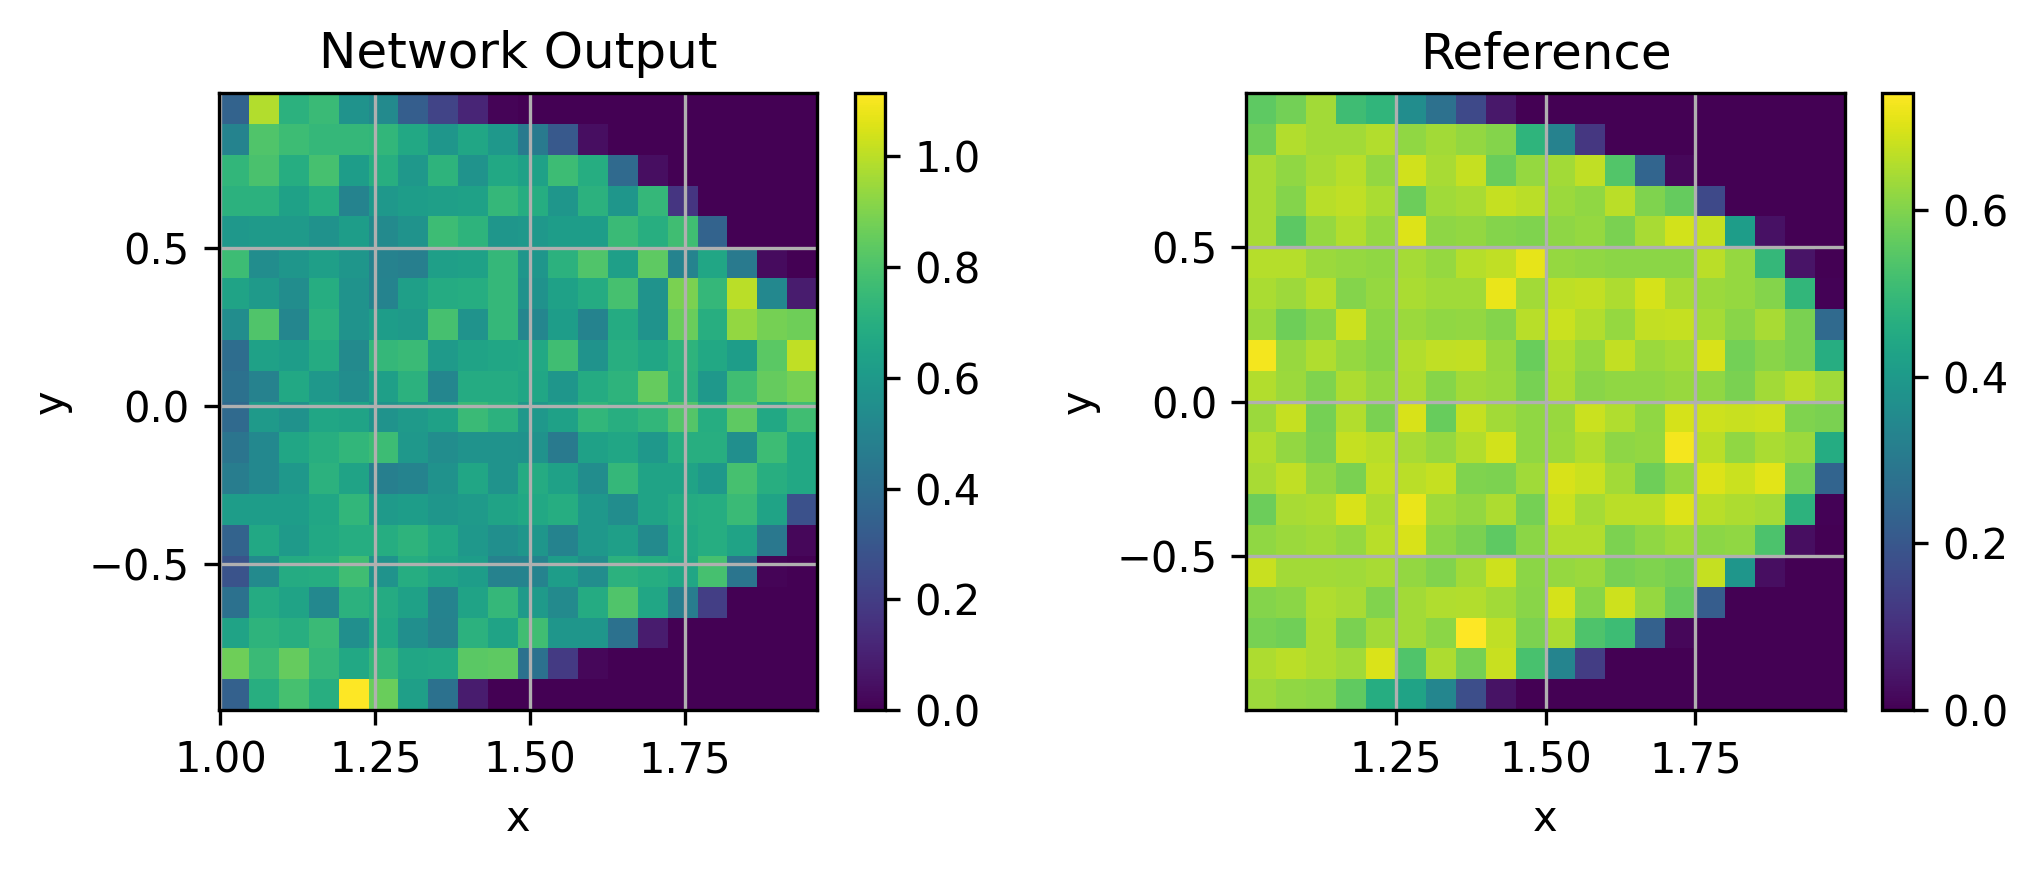

In [22]:
log2sigma_list=[0]
xpre=PredictDataGenerator(log2sigma=log2sigma_list,size=predict_size,rng_key=key_s)
params = model.get_params(model.opt_state)
f=jax.device_get(model.predict(params,xpre))
ref=dataset.data_set[:,:,3:]
for i in range(len(log2sigma_list)):
    fig = plt.figure(figsize=(7,3))
    
    ax=plt.subplot(1,2,2)
    lims=hist2dplot(ref[i*2,:,0],ref[i*2,:,1],ax,labels=['x','y'])
    ax.title.set_text('Reference')
    ax=plt.subplot(1,2,1)
    hist2dplot(f[i,:,0],f[i,:,1],ax,labels=['x','y'])
    ax.title.set_text('Network Output')
    plt.tight_layout()



In [23]:
params = model.get_params(model.opt_state)

# Save the trained model
flat_params, _  = ravel_pytree(model.get_params(model.opt_state))

# jnp.save(datafolder+'adv_params.npy', flat_params)
# jnp.save(datafolder+'adv_loss.npy', model.loss_log)

# #Restore the trained model
# flat_paaarams = jnp.load('adv_params.npy')
# params = model.unravel_params(flat_params)
# loss_log = np.load('adv_loss.npy')
